In [1]:
# importing the data
import pandas as pd
df=pd.read_csv(r"insurance.csv")

In [2]:
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
# Preparing X and Y variables
X = df.drop(columns=['expenses'],axis=1)
X

,age,sex,bmi,children,smoker,region
0,19,female,27.9,0,yes,southwest
1,18,male,33.8,1,no,southeast
2,28,male,33.0,3,no,southeast
3,33,male,22.7,0,no,northwest
4,32,male,28.9,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest
1334,18,female,31.9,0,no,northeast
1335,18,female,36.9,0,no,southeast
1336,21,female,25.8,0,no,southwest


In [4]:
y = df['expenses']
y

0       16884.92
1        1725.55
2        4449.46
3       21984.47
4        3866.86
          ...   
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
1337    29141.36
Name: expenses, Length: 1338, dtype: float64

In [5]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler 
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
## pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [6]:

num_features = X.select_dtypes(exclude="object").columns


oh_features=['sex']
od_features=['smoker','region']
# Define the custom ranking forordinal variable
smoker_map=['no','yes']
region_map=['northwest','southwest','northeast','southeast']


## Numerical Pipeline
num_pipeline=Pipeline(
    steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())])
# Categorigal Pipeline
cat_pipeline1=Pipeline(
    steps=[
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('ordinalencoder',OrdinalEncoder(categories=[smoker_map,region_map])),
        ('scaler',StandardScaler(with_mean=False))
        ])
cat_pipeline2=Pipeline(
    steps=[('imputer',SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder()),
        ('scaler',StandardScaler(with_mean=False))])


In [7]:
preprocessor=ColumnTransformer([
     ('num_pipeline',num_pipeline,num_features),
    ('cat_pipeline1',cat_pipeline1,od_features),
    ('cat_pipeline2',cat_pipeline2,oh_features)])
         

In [8]:
X = preprocessor.fit_transform(X)

In [9]:
X.shape

(1338, 7)

In [12]:
 preprocessor

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('cat_pipeline1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'yes'],
                                                                             ['northwest',
                                                                              'southwest',
                                                                              'northeast',
                                                                              'southeast']])),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['smoker', 'region']),
                                ('cat_pipeline2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot', OneHotEncoder()),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 ['sex'])])

In [15]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((1070, 7), (268, 7), (1070,), (268,))

In [19]:
# Convert the series to a DataFrame with a single column
y_test = y_test.to_frame()

# Access the underlying numpy array and reshape it
y_test = y_test.values.reshape(-1, 1)

In [23]:
y_test.shape

(268, 1)

In [24]:
# Convert the series to a DataFrame with a single column
y_train = y_train.to_frame()

# Access the underlying numpy array and reshape it
y_train = y_train.values.reshape(-1, 1)

In [25]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [33]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import numpy as np

In [34]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 6112.7673
- Mean Absolute Error: 4211.0968
- R2 Score: 0.7411
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5829.6974
- Mean Absolute Error: 4214.6638
- R2 Score: 0.7811


Lasso
Model performance for Training set
- Root Mean Squared Error: 6112.7670
- Mean Absolute Error: 4210.3714
- R2 Score: 0.7411
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5829.6451
- Mean Absolute Error: 4213.9515
- R2 Score: 0.7811


Ridge
Model performance for Training set
- Root Mean Squared Error: 6112.7745
- Mean Absolute Error: 4211.5078
- R2 Score: 0.7411
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5830.1906
- Mean Absolute Error: 4215.5580
- R2 Score: 0.7811


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 4304.7514
- Mean Absolute Error: 2575.3282


/tmp/ipykernel_6412/3073106053.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train) # Train model


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 1868.2435
- Mean Absolute Error: 1029.1199
- R2 Score: 0.9758
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4672.3459
- Mean Absolute Error: 2588.4007
- R2 Score: 0.8594


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 969.5351
- Mean Absolute Error: 527.2416
- R2 Score: 0.9935
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5037.3128
- Mean Absolute Error: 2928.7676
- R2 Score: 0.8366


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 2728.3716
- Mean Absolute Error: 1526.7885
- R2 Score: 0.9484
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 4606.1377
- Mean Absolute Error: 2594.8324
- R2 Score: 0.8633


AdaBoost Regressor
Model performance for Training set
- Root Mean Squared Error: 5078.4308
- Mean Ab

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.863339
5,Random Forest Regressor,0.859382
6,XGBRegressor,0.836556
3,K-Neighbors Regressor,0.833257
8,AdaBoost Regressor,0.806766
1,Lasso,0.781095
0,Linear Regression,0.781091
2,Ridge,0.781054
4,Decision Tree,0.721650


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
cat_model = CatBoostRegressor(verbose=False)
cat_model = cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 86.33


Text(0, 0.5, 'Predicted')

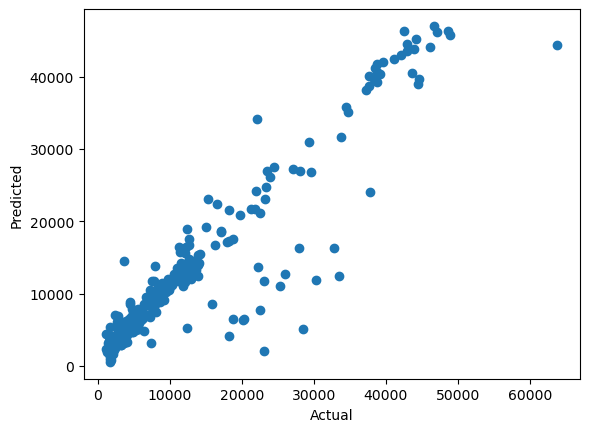

In [44]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<AxesSubplot: >

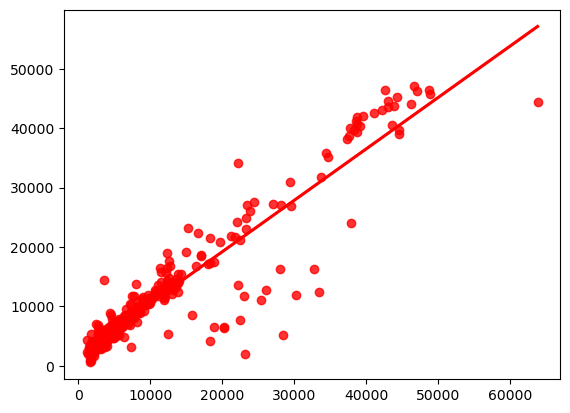

In [45]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')